## Cypto currency Leaders Analysis
Goal: <br>

--------
1. Identify the leaders
2. Extract the leaders' profile
3. Perform segmentation (clustering)
4. Ways to verify the analysis
--------


In [1]:
import pandas as pd
from datetime import datetime
import time
import matplotlib.pyplot as plt
import matplotlib.dates as md
import numpy as np
from datetime import timezone
from itertools import islice
from dateutil.relativedelta import relativedelta
import glob

In [2]:
# import prices of all tokens
all_token_price = pd.read_csv('all-time-price_27_tokens.csv')
# get all the files on wallets
all_csv = ['BLT.csv','DOCK.csv','ETK.csv','ETN.csv','EVX.csv','FAIR.csv','LEND.csv','MDA.csv','MWAT.csv',
           'MYST.csv','POE.csv','POWR.csv','RCN.csv','RMESH.csv','SUB.csv','TFD.csv','WPR.csv']
token_entry = pd.concat([pd.read_csv(file) for file in all_csv],ignore_index=True)
# convert the time from datetime to date
all_token_price['Time'] = pd.to_datetime(all_token_price['Time']).dt.date
token_entry['entry_time'] = pd.to_datetime(token_entry['entry_time']).dt.date

In [3]:
# join the two tables on token and time, perserving all wallet_id
token_wallet=pd.merge(all_token_price,token_entry,how='right',left_on=['Token','Time'],right_on=['Token','entry_time'])
token_wallet

,Token,Time,Price,Wallet_id,entry_time
0,BLT,2018-01-03,1.366,0x40eb2c0bd87b953273af6ec99ac204902a65b92e,2018-01-03
1,BLT,2018-01-03,1.366,0xe40a031442ae509f465ef3d5a5f01bc0e507a926,2018-01-03
2,BLT,2018-01-03,1.366,0xb528d2cafd2cc99fde613088fc7a7bde1cf3cb45,2018-01-03
3,BLT,2018-01-03,1.366,0x368eeff37b63f98bca2b03fe1ccaa082b01cd105,2018-01-03
4,BLT,2018-01-03,1.366,0x40ca70ef48e2a8c1d0f3e87596aefcac99c69ece,2018-01-03
...,...,...,...,...,...
789975,WPR,NaN,NaN,0x627f6783aa90992e6cbd32dfa96c55dfe1e55ce3,2020-11-04
789976,WPR,NaN,NaN,0xbd1b32d95dd537a28097bcd54d4fdc9681e3bda1,2020-11-04
789977,WPR,NaN,NaN,0x80b1b0105c5e5206a37a87bc596f7e6374436d42,2020-11-04
789978,WPR,NaN,NaN,0x95f734113b182a5890888f23d6f975b87562b343,2020-10-09


In [4]:
# join the two tables, only getting wallet_id on dates where prices are available
token_wallet1=pd.merge(all_token_price,token_entry,how='inner',left_on=['Token','Time'],right_on=['Token','entry_time'])
token_wallet1

,Token,Time,Price,Wallet_id,entry_time
0,BLT,2018-01-03,1.36600,0x40eb2c0bd87b953273af6ec99ac204902a65b92e,2018-01-03
1,BLT,2018-01-03,1.36600,0xe40a031442ae509f465ef3d5a5f01bc0e507a926,2018-01-03
2,BLT,2018-01-03,1.36600,0xb528d2cafd2cc99fde613088fc7a7bde1cf3cb45,2018-01-03
3,BLT,2018-01-03,1.36600,0x368eeff37b63f98bca2b03fe1ccaa082b01cd105,2018-01-03
4,BLT,2018-01-03,1.36600,0x40ca70ef48e2a8c1d0f3e87596aefcac99c69ece,2018-01-03
...,...,...,...,...,...
620051,WPR,2020-08-31,0.01154,0x05e2aa44d29bc2bf119d8ed3ca99fa2f27a27fe6,2020-08-31
620052,WPR,2020-08-31,0.01154,0xaec295dd8fe50082b4f40496e1561bf34da125d2,2020-08-31
620053,WPR,2020-09-01,0.01093,0x646eed52e9a9389e0af6807600bc297c2d321c82,2020-09-01
620054,WPR,2020-09-01,0.01093,0xa5b0e0fbca87d5139eca8b1aa4129e2a633e9a88,2020-09-01


In [5]:
# count number of entering wallets for each token each day, summarize into new table
wallet_count=token_wallet1.groupby(['Token','Time'])['Wallet_id'].count().reset_index(name='count')
# obtain the maximum 10 counts (count of entering wallets) for each token
top_entering_days=wallet_count.sort_values(['Token','count'],ascending=False).groupby('Token').head(10)
# get the wallets that entered a token on the days
import datetime
nDayWindow=7
top_entering_days['Time_nDayWindow']=top_entering_days['Time'] - datetime.timedelta(days=nDayWindow)
# get the number of wallet_ids
# first join on wallets to the top entering days, each wallet is joined with each of the top days
leaders=pd.merge(token_wallet1,top_entering_days,how='inner',on='Token')
# retain the row is the time of entering is in the range of satisfying days
# note that this will contain duplicates
time_constraint=((leaders['Time_x']>=leaders['Time_nDayWindow'])&(leaders['Time_x']<=leaders['Time_y']))
# retain the non-duplicate combination
token_leaders=leaders[time_constraint][['Token','Wallet_id','entry_time','Time_y','Price']].drop_duplicates()
# based on the leader candidates for each token, count how many times they are a leader
token_leaders1=token_leaders.groupby(['Wallet_id'])['Token'].count().reset_index(name='count')
# obtain the leaders entering dates and their number
token_leaders2=pd.merge(token_leaders,token_leaders1,on='Wallet_id')
td=top_entering_days[['Token','Time']]
td=pd.merge(td,token_wallet1[['Token','Time','Price']].drop_duplicates(),on=['Token','Time'])
td.rename(columns={'Time':'Time_y','Price':'Price_y'},inplace=True)
token_leaders2=pd.merge(token_leaders2,td,on=['Token','Time_y'])

In [6]:
token_leaders2['%price']=(token_leaders2['Price_y']-token_leaders2['Price'])/token_leaders2['Price']
token_leaders2['diff_days']=((pd.to_datetime(token_leaders['Time_y'],format='%Y-%m-%d'))-(pd.to_datetime(token_leaders2['entry_time']))).dt.days
token_leaders2

,Token,Wallet_id,entry_time,Time_y,Price,count,Price_y,%price,diff_days
0,BLT,0x40eb2c0bd87b953273af6ec99ac204902a65b92e,2018-01-03,2018-01-03,1.366000,1,1.366000,0.0,NaN
1,BLT,0xe40a031442ae509f465ef3d5a5f01bc0e507a926,2018-01-03,2018-01-03,1.366000,2,1.366000,0.0,NaN
2,BLT,0xb528d2cafd2cc99fde613088fc7a7bde1cf3cb45,2018-01-03,2018-01-03,1.366000,1,1.366000,0.0,0.0
3,BLT,0x368eeff37b63f98bca2b03fe1ccaa082b01cd105,2018-01-03,2018-01-03,1.366000,1,1.366000,0.0,NaN
4,BLT,0x40ca70ef48e2a8c1d0f3e87596aefcac99c69ece,2018-01-03,2018-01-03,1.366000,1,1.366000,0.0,NaN
...,...,...,...,...,...,...,...,...,...
677384,RMESH,0xd98eaeb1d51c41d9e539723a5c3bdce2f66d420b,2019-09-09,2019-09-09,0.009946,1,0.009946,0.0,NaN
677385,RMESH,0xe6e7d8d6830b8f11b2fc617a277f3759fce658f1,2019-09-09,2019-09-09,0.009946,1,0.009946,0.0,-593.0
677386,RMESH,0x0c95aa5b74a88bedb0420998bc017b8c1fff190d,2019-09-09,2019-09-09,0.009946,1,0.009946,0.0,-594.0
677387,RMESH,0x403b2c1d1cf4126a67f74e18db654e320e4b6233,2019-09-09,2019-09-09,0.009946,1,0.009946,0.0,-595.0


### Leaders and Laggards Part 1
Definition: <br>
Leaders: Wallets (influencers in crypto market) that are insightful about the market and make prompt decisions based on their observations. Ordinary crypto players may want to follow leaders to get more profit. <br>
Laggards: Wallets (crypto players) that are not sensitive about the market changes, falling behind market. <br>
This section focuses on identifying the cypto leaders/laggards using number of purchases. 

#### 1-1. Identify top purchasing peaks for each token

In [7]:
# the top entering days
# each token has 10 days selected
top_entering_days.head()

,Token,Time,count,Time_nDayWindow
13005,WPR,2018-03-24,16387,2018-03-17
13004,WPR,2018-03-23,7627,2018-03-16
12988,WPR,2018-03-07,2935,2018-02-28
13010,WPR,2018-03-29,2379,2018-03-22
12987,WPR,2018-03-06,1279,2018-02-27


In [15]:
# goal of this chunk: select M_i number of purchasing peak, each M_i correspond to a quartile of the 
import statistics
# obtain the tokens
tokens=token_entry['Token'].unique()
# get the count of entering wallets by token and entry_time
wallet_count=token_entry.groupby(['Token','entry_time'])['Wallet_id'].count().reset_index(name='counts')
# initiate the result table
top_days=pd.DataFrame(columns=['Token','entry_time','counts'])
# each tokens to be discussed seperatly
for token in tokens: 
    token_count=wallet_count[wallet_count.Token==token]
    quart=len(token_count)
    # select the top 1/4*totaldays
    quart_tc=token_count.sort_values(['counts'],ascending=False).head(quart)
    # the above criteron would leave lots of 1s
    # new criterion to select the median among those days
    # reduce 15748 rows to 8475 rows in total
    quart_tc=quart_tc[quart_tc.counts>=statistics.median(quart_tc.counts)]
    top_days=pd.concat([top_days,quart_tc])
top_days

,Token,entry_time,counts
42,BLT,2018-01-01,1215
10,BLT,2017-11-30,1168
9,BLT,2017-11-29,1132
41,BLT,2017-12-31,606
117,BLT,2018-03-17,453
...,...,...,...
15201,WPR,2019-06-07,9
15730,WPR,2020-11-21,9
15202,WPR,2019-06-08,9
15204,WPR,2019-06-10,9


In [16]:
# select the n_day periods and make function
def n_day_timeframe(df, time_str, n_day_start, n_day_end): 
    df=df.copy()
    df['nDay_start']=df[time_str]-datetime.timedelta(days=n_day_start)
    df['nDay_end']=df[time_str]-datetime.timedelta(days=n_day_end)
    return df

In [21]:
# seven days (1-week ago)
# those who purchase between 7 days and 1 day (1 week span) before purchasing peak
n7days=n_day_timeframe(top_days,'entry_time',7,1)
# 30 days (1-month ago)
# those who purchase between 30 days and 21 days (1 week span) before purchasing peak
n30days=n_day_timeframe(top_days,'entry_time',30,21)
# half year (182 days ago)
# those who purchase between 182 days and 152 days (1 month span) before purchasing peak
n182days=n_day_timeframe(top_days,'entry_time',182,152)
# one year (365 days ago)
# those who purchase between 365 days and 335 days (1 month span) before purchasing peak
n365days=n_day_timeframe(top_days,'entry_time',365,335)

In [45]:
def token_wallet(dt, entry, dl_str='nDay_start', dh_str='nDay_end'): 
    tokens=entry['Token'].unique()
    res_wallet=pd.DataFrame(columns=['Token', dl_str, dh_str, 'Wallet_id', 'entry_time'])
    for i in range(len(tokens)): 
        print(tokens[i],':', i+1, '/', len(tokens))
        temp_dt=dt[dt.Token==tokens[i]][['Token', dl_str, dh_str]]
        temp_wallet=pd.merge(temp_dt,entry,on='Token')
        temp_wallet=temp_wallet[ (temp_wallet.entry_time<=temp_wallet[dh_str]) & (temp_wallet.entry_time>=temp_wallet[dl_str]) ]
        res_wallet=pd.concat([res_wallet,temp_wallet])
    return res_wallet.reset_index()

In [46]:
n7days_wallet=token_wallet(n7days, token_entry)
n30days_wallet=token_wallet(n30days, token_entry)
n182days_wallet=token_wallet(n182days, token_entry)
n365days_wallet=token_wallet(n365days, token_entry)

BLT : 1 / 17
DOCK : 2 / 17
ETK : 3 / 17
ETN : 4 / 17
EVX : 5 / 17
FAIR : 6 / 17
LEND : 7 / 17
MDA : 8 / 17
MWAT : 9 / 17
MYST : 10 / 17
POE : 11 / 17
POWR : 12 / 17
RCN : 13 / 17
RMESH : 14 / 17
SUB : 15 / 17
TFD : 16 / 17
WPR : 17 / 17
BLT : 1 / 17
DOCK : 2 / 17
ETK : 3 / 17
ETN : 4 / 17
EVX : 5 / 17
FAIR : 6 / 17
LEND : 7 / 17
MDA : 8 / 17
MWAT : 9 / 17
MYST : 10 / 17
POE : 11 / 17
POWR : 12 / 17
RCN : 13 / 17
RMESH : 14 / 17
SUB : 15 / 17
TFD : 16 / 17
WPR : 17 / 17
BLT : 1 / 17
DOCK : 2 / 17
ETK : 3 / 17
ETN : 4 / 17
EVX : 5 / 17
FAIR : 6 / 17
LEND : 7 / 17
MDA : 8 / 17
MWAT : 9 / 17
MYST : 10 / 17
POE : 11 / 17
POWR : 12 / 17
RCN : 13 / 17
RMESH : 14 / 17
SUB : 15 / 17
TFD : 16 / 17
WPR : 17 / 17
BLT : 1 / 17
DOCK : 2 / 17
ETK : 3 / 17
ETN : 4 / 17
EVX : 5 / 17
FAIR : 6 / 17
LEND : 7 / 17
MDA : 8 / 17
MWAT : 9 / 17
MYST : 10 / 17
POE : 11 / 17
POWR : 12 / 17
RCN : 13 / 17
RMESH : 14 / 17
SUB : 15 / 17
TFD : 16 / 17
WPR : 17 / 17


In [75]:
n7days_counts=n7days_wallet[['Wallet_id','Token','entry_time']].groupby(by=['Wallet_id','Token','entry_time']).count().reset_index()
n7days_counts=n7days_counts[['Wallet_id','Token']].groupby('Wallet_id').count()
n7days_counts.rename(columns={'Token':'counts'},inplace=True)
n7days_counts.reset_index(inplace=True)
n7days_counts.sort_values(by='counts',ascending=False,inplace=True)
n7days_counts

,Wallet_id,counts
112037,0x2a0c0dbecc7e4d658f48e01e3fa353f44050c208,16
359804,0x8d12a197cb00d4747a1fe03395095ce2a5cc6819,14
235575,0x5ab9d116a53ef41063e3eae26a7ebe736720e9ba,13
363834,0x8ebd10fe696288c6ed1e024064fdf54541aa63e0,13
162913,0x3dee4a4e076e8d82859d241db0baf46f112cfa23,13
...,...,...
228092,0x57bb407f81b6aed46571961985f3f49187124189,1
228093,0x57bb4195c4dff5ba34fccb1d09c2dd50128c88cb,1
228094,0x57bb98f2f9c21d2300ed16c29e08c51b254c92bf,1
228096,0x57bbc639cc73a8abfc0bc4817ac053cef936a600,1


In [77]:
def wallet_count(nday_wallet):
    nday_count=nday_wallet[['Wallet_id','Token','entry_time']].groupby(by=['Wallet_id','Token','entry_time']).count().reset_index()
    nday_count=nday_count[['Wallet_id','Token']].groupby('Wallet_id').count()
    nday_count.rename(columns={'Token':'counts'},inplace=True)
    nday_count.reset_index(inplace=True)
    nday_count.sort_values(by='counts',ascending=False,inplace=True)
    return nday_count

In [78]:
n30days_counts=wallet_count(n30days_wallet)
n182days_counts=wallet_count(n182days_wallet)
n365days_counts=wallet_count(n365days_wallet)

In [80]:
n7days_counts.head(10)

,Wallet_id,counts
112037,0x2a0c0dbecc7e4d658f48e01e3fa353f44050c208,16
359804,0x8d12a197cb00d4747a1fe03395095ce2a5cc6819,14
235575,0x5ab9d116a53ef41063e3eae26a7ebe736720e9ba,13
363834,0x8ebd10fe696288c6ed1e024064fdf54541aa63e0,13
162913,0x3dee4a4e076e8d82859d241db0baf46f112cfa23,13
402559,0x9e9aede219c3074c9ad1e85bfa52fcf5f3cfd66e,13
445829,0xb0153aca2e1a162f5be062c5854942daa062c7c7,12
234842,0x5a6fc2de011d93842411aa5f91a0a4acd3feffde,12
35218,0x0c577fbf29f8797d9d29a33de59001b872a1d4dc,12
329018,0x809d596aa61c147355fce6478597646a04a5df3a,11


In [81]:
n30days_counts.head(10)

,Wallet_id,counts
111326,0x2a0c0dbecc7e4d658f48e01e3fa353f44050c208,16
357519,0x8d12a197cb00d4747a1fe03395095ce2a5cc6819,15
161805,0x3dee4a4e076e8d82859d241db0baf46f112cfa23,14
400023,0x9e9aede219c3074c9ad1e85bfa52fcf5f3cfd66e,13
233254,0x5a6fc2de011d93842411aa5f91a0a4acd3feffde,13
443031,0xb0153aca2e1a162f5be062c5854942daa062c7c7,13
361518,0x8ebd10fe696288c6ed1e024064fdf54541aa63e0,12
391009,0x9aebedadc45442e95146a7d5f45e84c66fac2db9,12
233991,0x5ab9d116a53ef41063e3eae26a7ebe736720e9ba,12
395413,0x9cb6247bf9e22da514b1b32acae28c560c73d848,11


In [82]:
n182days_counts.head(10)

,Wallet_id,counts
335266,0x8d12a197cb00d4747a1fe03395095ce2a5cc6819,17
104715,0x2a0c0dbecc7e4d658f48e01e3fa353f44050c208,16
219684,0x5ab9d116a53ef41063e3eae26a7ebe736720e9ba,13
415253,0xb0153aca2e1a162f5be062c5854942daa062c7c7,13
375084,0x9e9aede219c3074c9ad1e85bfa52fcf5f3cfd66e,13
219005,0x5a6fc2de011d93842411aa5f91a0a4acd3feffde,13
152153,0x3dee4a4e076e8d82859d241db0baf46f112cfa23,13
32972,0x0c577fbf29f8797d9d29a33de59001b872a1d4dc,12
563963,0xf124291b6387e046aaae24a7a1927d159b6f3f7b,12
155696,0x3f5ce5fbfe3e9af3971dd833d26ba9b5c936f0be,11


In [83]:
n365days_counts.head(10)

,Wallet_id,counts
312100,0x8d12a197cb00d4747a1fe03395095ce2a5cc6819,16
97601,0x2a0c0dbecc7e4d658f48e01e3fa353f44050c208,15
141735,0x3dee4a4e076e8d82859d241db0baf46f112cfa23,13
203981,0x5a6fc2de011d93842411aa5f91a0a4acd3feffde,13
348982,0x9e9aede219c3074c9ad1e85bfa52fcf5f3cfd66e,12
344950,0x9cb6247bf9e22da514b1b32acae28c560c73d848,11
145033,0x3f5ce5fbfe3e9af3971dd833d26ba9b5c936f0be,11
319432,0x9096410692868ea33f77ff1ca3ae3d9948faf82c,11
285480,0x809d596aa61c147355fce6478597646a04a5df3a,11
386304,0xb0153aca2e1a162f5be062c5854942daa062c7c7,11


In [62]:
token_entry[token_entry.Wallet_id=='0x2a0c0dbecc7e4d658f48e01e3fa353f44050c208']

,Token,Wallet_id,entry_time
7650,BLT,0x2a0c0dbecc7e4d658f48e01e3fa353f44050c208,2018-01-02
26888,DOCK,0x2a0c0dbecc7e4d658f48e01e3fa353f44050c208,2018-04-25
91128,ETK,0x2a0c0dbecc7e4d658f48e01e3fa353f44050c208,2018-02-14
101764,EVX,0x2a0c0dbecc7e4d658f48e01e3fa353f44050c208,2017-10-10
137116,FAIR,0x2a0c0dbecc7e4d658f48e01e3fa353f44050c208,2018-07-01
172837,LEND,0x2a0c0dbecc7e4d658f48e01e3fa353f44050c208,2017-12-01
331996,MDA,0x2a0c0dbecc7e4d658f48e01e3fa353f44050c208,2017-12-17
348230,MWAT,0x2a0c0dbecc7e4d658f48e01e3fa353f44050c208,2018-02-11
374643,MYST,0x2a0c0dbecc7e4d658f48e01e3fa353f44050c208,2017-09-28
409202,POE,0x2a0c0dbecc7e4d658f48e01e3fa353f44050c208,2018-01-04


In [85]:
n7days_walletids=token_entry[token_entry.Wallet_id.isin(n7days_counts['Wallet_id'])]
n7days_wallet_total_count=n7days_walletids[['Token','Wallet_id']].groupby('Wallet_id').count().rename(columns={'Token':'Total_counts'}).reset_index()
# merge same token/wallet_id together
n7days_wallet_token_count=n7days_walletids.groupby(['Token','Wallet_id']).count().reset_index()
# count the number of unique tokens purchased per wallet_id
n7days_wallet_token_count=n7days_wallet_token_count[['Token','Wallet_id']].groupby('Wallet_id').count().rename(columns={'Token':'Token_counts'}).reset_index()

In [94]:
n7days_wallet_sum=pd.merge(n7days_counts,n7days_wallet_total_count,on='Wallet_id')
n7days_wallet_sum=pd.merge(n7days_wallet_sum,n7days_wallet_token_count,on='Wallet_id')

In [98]:
n7days_wallet_sum[n7days_wallet_sum.Token_counts!=n7days_wallet_sum.counts]

,Wallet_id,counts,Total_counts,Token_counts
1,0x8d12a197cb00d4747a1fe03395095ce2a5cc6819,14,17,17
4,0x3dee4a4e076e8d82859d241db0baf46f112cfa23,13,14,14
6,0xb0153aca2e1a162f5be062c5854942daa062c7c7,12,13,13
7,0x5a6fc2de011d93842411aa5f91a0a4acd3feffde,12,13,13
13,0xfd752e65b20c97534f09d4e67bbb537650e6f833,11,12,12
...,...,...,...,...
642154,0x57b44e0822210c39077f893047f3ef2c79206af9,1,2,2
642188,0x57a6d062c1bd4982c90b109a896073e1c3ae985f,1,2,2
642208,0x57a4c7c267afdf07bc8c9f8faa46a43ad5ccb688,1,2,2
642270,0x57c0322622ec84d52be97c32a245c124e2ab480e,1,2,2


In [99]:
def wallet_sum(token_entry, nday_counts):
    nday_walletids=token_entry[token_entry.Wallet_id.isin(nday_counts['Wallet_id'])]
    nday_wallet_total_count=nday_walletids[['Token','Wallet_id']].groupby('Wallet_id').count().rename(columns={'Token':'Total_counts'}).reset_index()
    # merge same token/wallet_id together
    nday_wallet_token_count=nday_walletids.groupby(['Token','Wallet_id']).count().reset_index()
    # count the number of unique tokens purchased per wallet_id
    nday_wallet_token_count=nday_wallet_token_count[['Token','Wallet_id']].groupby('Wallet_id').count().rename(columns={'Token':'Token_counts'}).reset_index()
    nday_wallet_sum=pd.merge(nday_counts,nday_wallet_total_count,on='Wallet_id')
    nday_wallet_sum=pd.merge(nday_wallet_sum,nday_wallet_token_count,on='Wallet_id')
    return nday_wallet_sum

In [100]:
n30days_wallet_sum=wallet_sum(token_entry,n30days_counts)
n182days_wallet_sum=wallet_sum(token_entry,n182days_counts)
n365days_wallet_sum=wallet_sum(token_entry,n365days_counts)

In [101]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

In [105]:
range_n_clusters = [2, 3,]
X=n7days_wallet_sum[['counts','Total_counts','Token_counts']]
silhoutte=[]
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhoutte.append(silhouett_avg)
silhouette

NameError: name 'silhouett_avg' is not defined

In [102]:
n7days_wallet_sum

,Wallet_id,counts,Total_counts,Token_counts
0,0x2a0c0dbecc7e4d658f48e01e3fa353f44050c208,16,16,16
1,0x8d12a197cb00d4747a1fe03395095ce2a5cc6819,14,17,17
2,0x5ab9d116a53ef41063e3eae26a7ebe736720e9ba,13,13,13
3,0x8ebd10fe696288c6ed1e024064fdf54541aa63e0,13,13,13
4,0x3dee4a4e076e8d82859d241db0baf46f112cfa23,13,14,14
...,...,...,...,...
642399,0x57bb407f81b6aed46571961985f3f49187124189,1,1,1
642400,0x57bb4195c4dff5ba34fccb1d09c2dd50128c88cb,1,1,1
642401,0x57bb98f2f9c21d2300ed16c29e08c51b254c92bf,1,1,1
642402,0x57bbc639cc73a8abfc0bc4817ac053cef936a600,1,1,1


### Leader and laggard
A laggard is a stock or security that is underperforming relative to its benchmark or peers. A laggard will have lower-than-average returns compared to the market. A laggard is the opposite of a leader. 
 - A laggard underperforms its benchmark, in terms of an investment's returns.
 - If an investor holds laggards in their portfolio, these are generally the first candidates for selling.
 - Investors may mistake a laggard for a bargain, but these will carry excess risk. <br>
 
The 

In [ ]:
# preparation, get the data
tokens=token_entry['Token'].unique()
atoken_prices=all_token_price[all_token_price['Token'].isin(tokens)]
atoken_prices.reset_index(drop=True,inplace=True)

In [ ]:
def leaderboard(entry,prices,nday):
    # select the tokens whose entry are available
    tokens=entry['Token'].unique()

In [129]:
# blockchain leaders and laggards
# select tokens based on percentage changes in prices

# atoken_prices contain only the available prices
# col: Token, Time, Price
# create a new column that is n-day before the current date
nday=datetime.timedelta(5)
atoken_prices=atoken_prices.copy()
atoken_prices['nTime']=atoken_prices['Time']-nday
# join the token prices on dates that is n-day away, perserving all dates
newdates=atoken_prices[['Token','Time','Price']]
newdates.columns=['Token','nTime','nPrice']
atoken_prices=pd.merge(atoken_prices,newdates,how='left',on=['Token','nTime'])
# drop na, i.e. the first five dates
atoken_prices=atoken_prices.dropna()
# calculate the percentage differences in prices
atoken_prices['diff_%']=(atoken_prices['nPrice']-atoken_prices['Price'])/atoken_prices['nPrice']

In [130]:
# not all price data is available throughout the period
# get the period where price data for all tokens are available
min_time=atoken_prices[['Token','Time']].groupby(by=['Token']).min()
max_time=atoken_prices[['Token','Time']].groupby(by=['Token']).max()
min_time=max(min_time['Time'])
max_time=min(max_time['Time'])
filtered_price=atoken_prices[(atoken_prices['Time']>=min_time)&(atoken_prices['Time']<=max_time)]

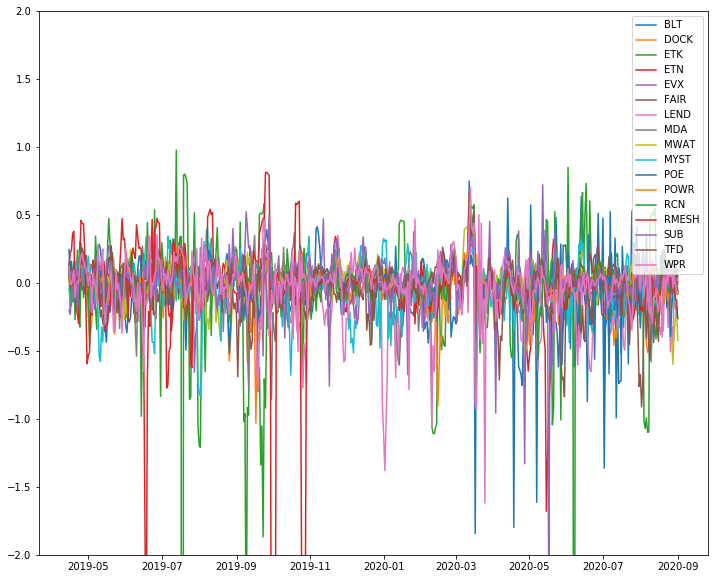

In [88]:
plt.figure(figsize=(12,10))
for token in tokens: 
    t1=filtered_price[filtered_price['Token']==token][['Time','diff_%']]
    plt.plot(t1['Time'],t1['diff_%'], label=token)
plt.ylim(-2,2)
plt.legend()

In [131]:
# identify the leaders and laggard at specific times
# use first quartile and third quartile of current price difference to determine leaders and laggard
# obtain the first (lower bound) and third (upper bound) quartile of each time
def q1(x):
    return x.quantile(0.25)
def q2(x):
    return x.quantile(0.75)
f = {'diff_%':[q1,q2]}
quartile_prices=filtered_price[['Token','Time','diff_%']].groupby(by=['Time']).agg(f)
quartile_prices=quartile_prices['diff_%'].reset_index()
# join quartile prices with current price list on dates
filtered_price=pd.merge(filtered_price,quartile_prices,on='Time')
# identify leader and laggard
filtered_price['leader']=np.where(filtered_price['diff_%']>=filtered_price.q2,1,0)
filtered_price['laggard']=np.where(filtered_price['diff_%']<=filtered_price.q1,1,0)

In [185]:
filtered_price.head()

,Token,Time,Price,nTime,nPrice,diff_%,q1,q2,leader,laggard
0,BLT,2019-04-15,0.071230,2019-04-10,0.094510,0.246323,0.052263,0.128248,1,0
1,DOCK,2019-04-15,0.013440,2019-04-10,0.014960,0.101604,0.052263,0.128248,0,0
2,ETN,2019-04-15,0.005630,2019-04-10,0.006429,0.124281,0.052263,0.128248,0,0
3,ETK,2019-04-15,0.000756,2019-04-10,0.000851,0.112103,0.052263,0.128248,0,0
4,LEND,2019-04-15,0.010400,2019-04-10,0.011930,0.128248,0.052263,0.128248,1,0


In [138]:
token_entry.head()

,Token,Wallet_id,entry_time
0,BLT,0x2e18dcbd51f6c24270a94324920f4c2a3ae7fe7e,2018-01-28
1,BLT,0x3913893d866c1c05d3cabe9a4e568f605bbc7673,2017-12-03
2,BLT,0x6dce23bae98934ecbd00c5bdae4312288d956877,2017-12-31
3,BLT,0x3dc768eb0a77c54215f37206401df32d9028d974,2018-01-09
4,BLT,0x2f3593fb5a2b151f1586c77dd687b045fe4e79cc,2019-07-03


In [195]:
# is filtered price associated with large purchase
entries=token_entry.groupby(by=['Token','entry_time']).count()
e1=entries.reset_index()
e1.columns=['Token','nTime','nWallet_count']
e2=entries.reset_index()
e2.columns=['Token','Time','wallet_count']
entry_price=pd.merge(filtered_price,e1,on=['Token','nTime'])
entry_price=pd.merge(entry_price,e2,on=['Token','Time'])

In [196]:
entry_price

,Token,Time,Price,nTime,nPrice,diff_%,q1,q2,leader,laggard,nWallet_count,wallet_count
0,BLT,2019-04-15,0.071230,2019-04-10,0.094510,0.246323,0.052263,0.128248,1,0,4,3
1,DOCK,2019-04-15,0.013440,2019-04-10,0.014960,0.101604,0.052263,0.128248,0,0,15,5
2,ETK,2019-04-15,0.000756,2019-04-10,0.000851,0.112103,0.052263,0.128248,0,0,2,2
3,LEND,2019-04-15,0.010400,2019-04-10,0.011930,0.128248,0.052263,0.128248,1,0,15,47
4,EVX,2019-04-15,0.807600,2019-04-10,0.927900,0.129648,0.052263,0.128248,1,0,7,7
...,...,...,...,...,...,...,...,...,...,...,...,...
5908,POE,2020-09-01,0.002764,2020-08-27,0.002912,0.050824,-0.076118,0.017172,1,0,12,2
5909,POWR,2020-09-01,0.113100,2020-08-27,0.105100,-0.076118,-0.076118,0.017172,0,1,36,45
5910,RCN,2020-09-01,0.059600,2020-08-27,0.065720,0.093122,-0.076118,0.017172,1,0,28,26
5911,TFD,2020-09-01,0.020540,2020-08-27,0.024290,0.154385,-0.076118,0.017172,1,0,6,6


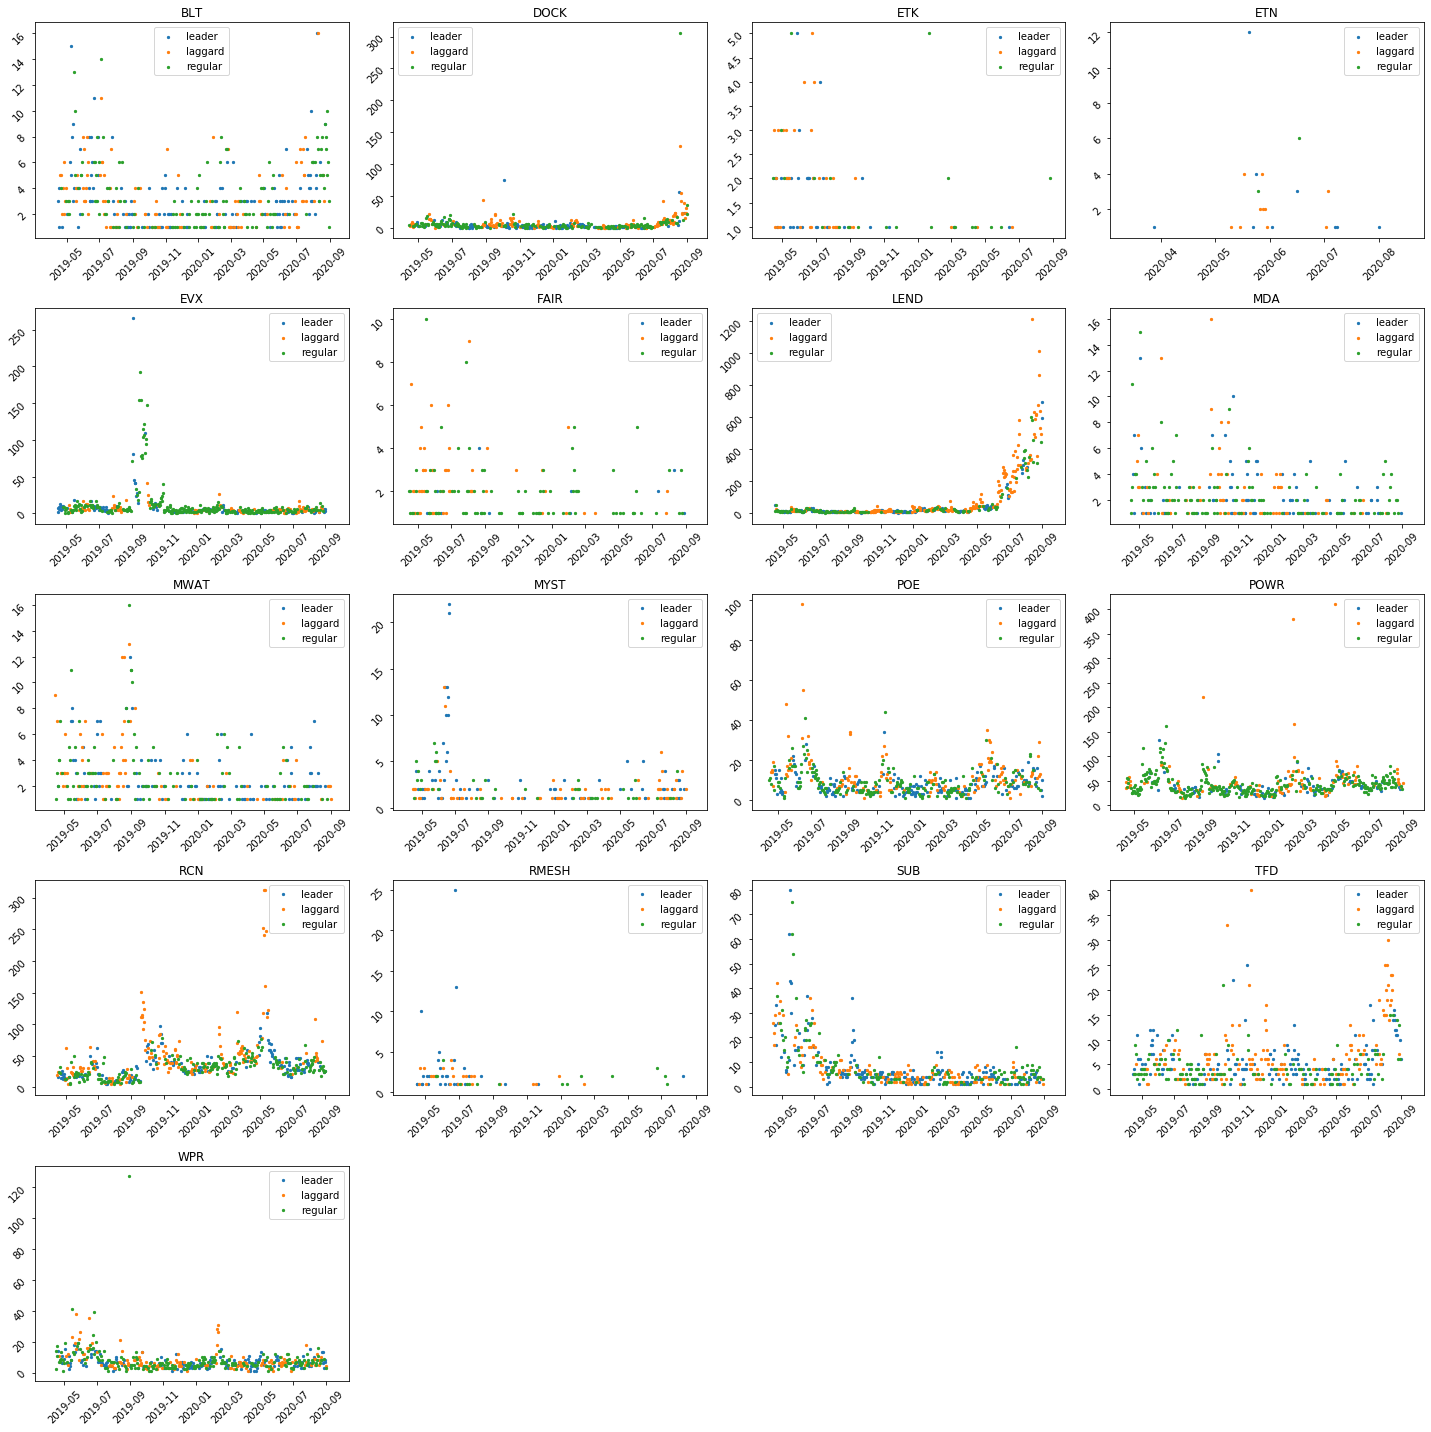

In [300]:
%matplotlib inline
plt.figure(figsize=(20,20))
plots=[]
for i in range(5):
    for j in range(4): 
        if (i < 4) or ((i==4)&(j<1)):
            ax=plt.subplot2grid((5,4),(i,j))
            df=entry_price[entry_price['Token']==tokens[i*4+j]][['Time','leader','laggard','wallet_count']]
            ax.scatter(df[df['leader']==1]['Time'],df[df['leader']==1]['wallet_count'],label='leader',s=5)
            ax.scatter(df[df['laggard']==1]['Time'],df[df['laggard']==1]['wallet_count'],label='laggard',s=5)
            ax.scatter(df[(df['leader']==0)&(df['laggard']==0)]['Time'],df[(df['leader']==0)&(df['laggard']==0)]['wallet_count'],label='regular',s=5)
            ax.tick_params(labelrotation=45)
            ax.set_title(tokens[i*4+j])
            ax.legend()
plt.tight_layout()
plt.show()     

In [311]:
def plot_wallet_entry(df,current_token):
    df=df[df['Token']==current_token][['Time','leader','laggard','wallet_count']]
    plt.scatter(df[df['leader']==1]['Time'],df[df['leader']==1]['wallet_count'],label='leader',s=5)
    plt.scatter(df[df['laggard']==1]['Time'],df[df['laggard']==1]['wallet_count'],label='laggard',s=5)
    plt.scatter(df[(df['leader']==0)&(df['laggard']==0)]['Time'],df[(df['leader']==0)&(df['laggard']==0)]['wallet_count'],label='regular',s=5)
    plt.xlabel('Date')
    plt.ylabel('Number of Entries')
    plt.xticks(rotation=45)
    plt.legend()
    plt.show()

In [316]:
%matplotlib qt
plot_wallet_entry(entry_price,'RCN')

In [197]:
# get the wallets that entered n-days ago
# get the leader board
price_leader=entry_price[entry_price['leader']==1]
# get the wallet that made the purchase on nth day
te=token_entry.copy()
te.columns=['Token','Wallet_id','nTime']
price_leader=pd.merge(price_leader,te,how='left',on=['Token','nTime'])
price_leader

,Token,Time,Price,nTime,nPrice,diff_%,q1,q2,leader,laggard,nWallet_count,wallet_count,Wallet_id
0,BLT,2019-04-15,0.07123,2019-04-10,0.09451,0.246323,0.052263,0.128248,1,0,4,3,0x50e125ed9945383a7cc85af03ac0f7bc347be457
1,BLT,2019-04-15,0.07123,2019-04-10,0.09451,0.246323,0.052263,0.128248,1,0,4,3,0x821aeb2a5442c95cd2dbf8dd8c19491dd29bf8c1
2,BLT,2019-04-15,0.07123,2019-04-10,0.09451,0.246323,0.052263,0.128248,1,0,4,3,0x878f4c848c505507a79a60929f0ede6137f41302
3,BLT,2019-04-15,0.07123,2019-04-10,0.09451,0.246323,0.052263,0.128248,1,0,4,3,0x7659afa68f66e30ef51be018d0121c4ac9146a40
4,LEND,2019-04-15,0.01040,2019-04-10,0.01193,0.128248,0.052263,0.128248,1,0,15,47,0xf6abbd216b5e6975353ccfe54a73539a4537488d
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26714,TFD,2020-09-01,0.02054,2020-08-27,0.02429,0.154385,-0.076118,0.017172,1,0,6,6,0x2c15c4f6974febb7e2d9980a3fbb76838c2bd375
26715,TFD,2020-09-01,0.02054,2020-08-27,0.02429,0.154385,-0.076118,0.017172,1,0,6,6,0xa4a8391b30842b3dc1e8db1bf95e410d8adf1d05
26716,TFD,2020-09-01,0.02054,2020-08-27,0.02429,0.154385,-0.076118,0.017172,1,0,6,6,0xffe24544f86593680cf28ca7bc2916980bd35453
26717,TFD,2020-09-01,0.02054,2020-08-27,0.02429,0.154385,-0.076118,0.017172,1,0,6,6,0x0ee22e01013e6c429297001fa0560f04c72c5223


In [198]:
price_leader.describe()

,Price,nPrice,diff_%,q1,q2,leader,laggard,nWallet_count,wallet_count
count,26719.000000,26719.000000,26719.000000,26719.000000,26719.000000,26719.0,26719.0,26719.000000,26719.000000
mean,0.133887,0.148213,0.107127,-0.057241,0.056827,1.0,0.0,144.048467,92.175156
std,0.204037,0.223530,0.095634,0.088842,0.078331,0.0,0.0,232.934946,158.722912
min,0.000011,0.000167,-0.191860,-0.375617,-0.192216,1.0,0.0,1.000000,1.000000
25%,0.015860,0.020000,0.041461,-0.115244,0.010607,1.0,0.0,15.000000,10.000000
50%,0.055980,0.058970,0.091619,-0.058954,0.046013,1.0,0.0,41.000000,32.000000
75%,0.117500,0.126200,0.145420,-0.003035,0.091140,1.0,0.0,135.000000,70.000000
max,1.152000,1.411000,0.976820,0.447857,0.631973,1.0,0.0,1011.000000,696.000000


In [199]:
price_laggard=entry_price[entry_price['laggard']==1]
price_laggard.describe()

,Price,nPrice,diff_%,q1,q2,leader,laggard,nWallet_count,wallet_count
count,1795.000000,1795.000000,1795.000000,1795.000000,1795.000000,1795.0,1795.0,1795.000000,1795.000000
mean,0.093610,0.081861,-0.189620,-0.058605,0.051386,0.0,1.0,21.046797,25.529805
std,0.192699,0.168484,0.471042,0.088336,0.079385,0.0,0.0,62.093593,75.773503
min,0.000074,0.000011,-17.666667,-0.375617,-0.192216,0.0,1.0,1.000000,1.000000
25%,0.006102,0.005397,-0.237542,-0.116672,0.005691,0.0,1.0,3.000000,3.000000
50%,0.019190,0.015830,-0.132602,-0.059690,0.038546,0.0,1.0,6.000000,6.000000
75%,0.066870,0.058110,-0.058889,-0.003865,0.086839,0.0,1.0,15.500000,19.000000
max,1.411000,1.092000,0.423510,0.447857,0.631973,0.0,1.0,1214.000000,1214.000000


In [265]:
# get the accounts grouped together
pl=price_leader[['Token','nTime','Wallet_id']]
# two wallet_ids are said to be the connected together if they purchased leader token 5 days ago together
leader_connect=pd.merge(pl,pl,on=['Token','nTime'])
leader_connect=leader_connect[leader_connect['Wallet_id_x']!=leader_connect['Wallet_id_y']]
# calculate the number of times two wallets purchase together
leader_connect=leader_connect[['Wallet_id_x','Wallet_id_y','Token']].groupby(by=['Wallet_id_x','Wallet_id_y']).count()
leader_connect.reset_index(inplace=True)
leader_connect.columns=['Wallet_id_x','Wallet_id_y','weight']
leader_connect

,Wallet_id_x,Wallet_id_y,weight
0,0x000000000000006f6502b7f2bbac8c30a3f67e9a,0x009045bd93cc7f8ea55a80741e8754db5b1167a2,1
1,0x000000000000006f6502b7f2bbac8c30a3f67e9a,0x00cc14ee7342015c19ac0db4d2c30668c899bbec,1
2,0x000000000000006f6502b7f2bbac8c30a3f67e9a,0x026857fa26d2ef304b5fe211ffc0ea975f36e6a7,1
3,0x000000000000006f6502b7f2bbac8c30a3f67e9a,0x05a2551f404fe3987f575fcb082f4f968a2ebd3d,1
4,0x000000000000006f6502b7f2bbac8c30a3f67e9a,0x06f581c1a6fd532f9d7faddf27ede4f6a407f4e2,1
...,...,...,...
3821805,0xffff88215f3f54b1eddb93b8ae5770be6f04b864,0x5b005e2bd2d84b61d1bea16a59215f7d42a27edf,1
3821806,0xffff88215f3f54b1eddb93b8ae5770be6f04b864,0x65d50abc586a551e867ddb111b7c8956c0b5091f,1
3821807,0xffff88215f3f54b1eddb93b8ae5770be6f04b864,0x6794958a12713fee7e6d1e307629afe2c7cf942c,1
3821808,0xffff88215f3f54b1eddb93b8ae5770be6f04b864,0x6a0f7d06e70e64d0e510a9717b80964d0ec1c037,1


In [270]:
# get the accounts on the two days following the nday purchase
# on n=5, ntime is 5 days before, ntime_1dayafter is 4 days before
day1,day2=datetime.timedelta(1),datetime.timedelta(2)
pl1=entry_price[['Token','Time','nTime']].copy()
pl1['nTime_1dayafter']=pl1['nTime']+day1
# get the wallet id for the 1 and 2 days after ntime
pl1=pd.merge(pl1,token_entry,how='left',left_on=['Token','nTime_1dayafter'],right_on=['Token','entry_time'])
pl1=pl1[['Token','nTime','Wallet_id']]
# join the second-tie wallet with the first day purchases
pl2=price_leader[['Token','nTime','Wallet_id']]
pl=pd.merge(pl1,pl2,on=['Token','nTime'])
pl['weight']=0.7
pll=pd.merge(pl1,pl1,on=['Token','nTime'])
pll['weight']=1
pl_cross=pd.concat([pl,pll],ignore_index=True)
pl_cross=pl_cross[['weight','Wallet_id_x','Wallet_id_y']].groupby(by=['Wallet_id_x','Wallet_id_y']).sum()
pl_cross.reset_index(inplace=True)
pl_cross

,Wallet_id_x,Wallet_id_y,weight
0,0x0000000000000000000000000000000000000000,0x0000000000000000000000000000000000000000,1.0
1,0x0000000000000000000000000000000000000000,0x02e41cff83757bf71360bcce9ce019c0c93391f8,1.0
2,0x0000000000000000000000000000000000000000,0x03f586424d0a1ae926c5628e2acbf0309b80ee06,1.0
3,0x0000000000000000000000000000000000000000,0x05ff93312c6c0f5df2b3409a561770849ec1d9d5,1.0
4,0x0000000000000000000000000000000000000000,0x0b8ed3ebc2f0ec96cd8d293232dca20bfd5b13db,1.0
...,...,...,...
18787522,0xffff88215f3f54b1eddb93b8ae5770be6f04b864,0xef0b01b87a6e6f56ccb4570c23f93e2c989b277c,0.7
18787523,0xffff88215f3f54b1eddb93b8ae5770be6f04b864,0xf24129aaf9b1b70940077fadc0a9164729e5b958,1.0
18787524,0xffff88215f3f54b1eddb93b8ae5770be6f04b864,0xf82989063859b28249e3f0ac37e016d98a8a7ab7,2.0
18787525,0xffff88215f3f54b1eddb93b8ae5770be6f04b864,0xf9b5d9776316eb251688ce7aaf9a349e16b3a0c1,1.0


In [268]:
pl

,Token,nTime,Wallet_id
0,BLT,2019-04-10,0x50e125ed9945383a7cc85af03ac0f7bc347be457
1,BLT,2019-04-10,0x821aeb2a5442c95cd2dbf8dd8c19491dd29bf8c1
2,BLT,2019-04-10,0x878f4c848c505507a79a60929f0ede6137f41302
3,BLT,2019-04-10,0x7659afa68f66e30ef51be018d0121c4ac9146a40
4,LEND,2019-04-10,0xf6abbd216b5e6975353ccfe54a73539a4537488d
...,...,...,...
26714,TFD,2020-08-27,0x2c15c4f6974febb7e2d9980a3fbb76838c2bd375
26715,TFD,2020-08-27,0xa4a8391b30842b3dc1e8db1bf95e410d8adf1d05
26716,TFD,2020-08-27,0xffe24544f86593680cf28ca7bc2916980bd35453
26717,TFD,2020-08-27,0x0ee22e01013e6c429297001fa0560f04c72c5223


In [286]:
# get only the necessary ones
lc1=leader_connect[leader_connect['weight']>1]
lc=pd.concat([lc1,pl_cross],ignore_index=True,sort=False)
# add two conditions together
lc=lc.groupby(by=['Wallet_id_x','Wallet_id_y']).sum()
lc.reset_index(inplace=True)
lc=lc[(lc['weight']>1)&(lc['Wallet_id_x']!=lc['Wallet_id_y'])]
lc

,Wallet_id_x,Wallet_id_y,weight
1847,0x000000000025d4386f7fb58984cbe110aee3a4c4,0x0ec888801d4739052a9d6ddd79500358e0fbf29c,1.7
1987,0x000000000025d4386f7fb58984cbe110aee3a4c4,0x4e0a0f8161c47e50ac829e3e26f800ab687e5e6a,1.7
2201,0x000000000025d4386f7fb58984cbe110aee3a4c4,0xa2dd56f02bcdd8b5c3cfaf9d47f655f0c8cb90a5,1.7
5092,0x00000000af5a61acaf76190794e3fdf1289288a1,0xb81a1bd9b09fe94203a15be3ad0af59b9d5e8b64,1.4
5291,0x00000000b1786c9698c160d78232c78d6f6474fe,0xc640caba272414689b21ebcd60d97b912359504d,2.0
...,...,...,...
18787398,0xffff46e05a09314daae9176fc32dba0f4172dcdb,0xcf1f2e33c86186592b9cf4416f4b3930a4ee5d71,2.0
18787457,0xffff88215f3f54b1eddb93b8ae5770be6f04b864,0x5b005e2bd2d84b61d1bea16a59215f7d42a27edf,2.0
18787464,0xffff88215f3f54b1eddb93b8ae5770be6f04b864,0x65d50abc586a551e867ddb111b7c8956c0b5091f,2.0
18787468,0xffff88215f3f54b1eddb93b8ae5770be6f04b864,0x6a0f7d06e70e64d0e510a9717b80964d0ec1c037,2.0


In [288]:
lc[lc['weight']>5]

,Wallet_id_x,Wallet_id_y,weight
1019659,0x0d1024c7fcd5badd00588fb5253db439135418bc,0xbe0eb53f46cd790cd13851d5eff43d12404d33e8,6.0
2230498,0x1dbe26e68c412e70e27c95cd3fcd739f50b081db,0x446cf556feef3032a7357f43d5973ca51ad152cc,6.0
2728266,0x2501b4e444bb5d093c71d03e0f82c2d8d000dbe3,0xe2c9b2ffece90f4f757cf47986ed6ed5cf1770b0,6.0
2728293,0x2501b4e444bb5d093c71d03e0f82c2d8d000dbe3,0xef3522301da6b8dc7fb1ca44eb42532c59f0936b,5.7
4477951,0x3cc89fa9aa5f638d4e2c61ef142b60f6099597ce,0x5d1c239b0a50f1ea7554167f7463c7a2d7a6b628,6.0
4478049,0x3cc89fa9aa5f638d4e2c61ef142b60f6099597ce,0xe5a7a575c192380ab95b48780763fbbf000f10b8,6.0
5045199,0x446cf556feef3032a7357f43d5973ca51ad152cc,0x1dbe26e68c412e70e27c95cd3fcd739f50b081db,6.0
5405272,0x49830050b244b48c2fdadf79f0961c830477a6fb,0x60ff4c0dfc28151a6ff64c1534e7727a9e480fa8,6.0
5405319,0x49830050b244b48c2fdadf79f0961c830477a6fb,0x8110caeb7239d1972e50ecf7738dcef9febc1b25,6.7
5405384,0x49830050b244b48c2fdadf79f0961c830477a6fb,0xb05e7b88aee57efc831c21407abf7d8be5bfea39,9.0


In [289]:
import networkx as nx
g=nx.from_pandas_edgelist(lc[lc['weight']>5],source='Wallet_id_x',target='Wallet_id_y')

In [292]:
%matplotlib qt
plt.figure(figsize=(20,10))
nx.draw_random(g,with_labels=True)
plt.show()

In [8]:
import tslearn
tokens=token_entry['Token'].unique()
part_token_price=all_token_price[all_token_price['Token'].isin(tokens)]

In [9]:
#!pip install -U scikit-learn --user
from tslearn.clustering import TimeSeriesKMeans

In [13]:
part_token_price

,Token,Time,Price
946,BLT,2018-01-03,1.36600
947,BLT,2018-01-04,1.34200
948,BLT,2018-01-05,2.59200
949,BLT,2018-01-06,1.91200
950,BLT,2018-01-07,1.95600
...,...,...,...
28218,WPR,2020-08-28,0.01073
28219,WPR,2020-08-29,0.01068
28220,WPR,2020-08-30,0.01052
28221,WPR,2020-08-31,0.01154


In [22]:
from tslearn.utils import to_time_series
bb=to_time_series(part_token_price[part_token_price['Token']=='BLT'][['Price']])
model=TimeSeriesKMeans(n_clusters=3, metric="dtw", max_iter=10)
model.fit(bb)
y_pred=model.fit_predict(bb)

TimeSeriesKMeans(max_iter=10, metric='dtw')

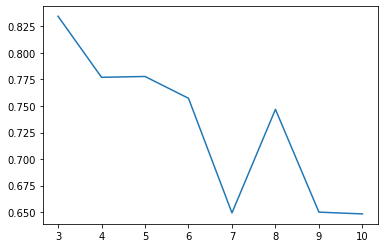

In [36]:
from tslearn.clustering import silhouette_score
import matplotlib.pyplot as plt
n=10
silhouette=[]
for i in range(3,n+1): 
    n_clt=i
    model=TimeSeriesKMeans(n_clusters=n_clt, metric="dtw", max_iter=10)
    model.fit(bb)
    y_pred=model.fit_predict(bb)
    silhouette.append(silhouette_score(bb,y_pred))
plt.plot([i for i in range(3,n+1)],silhouette)
plt.show()

In [41]:
len(tokens)

17

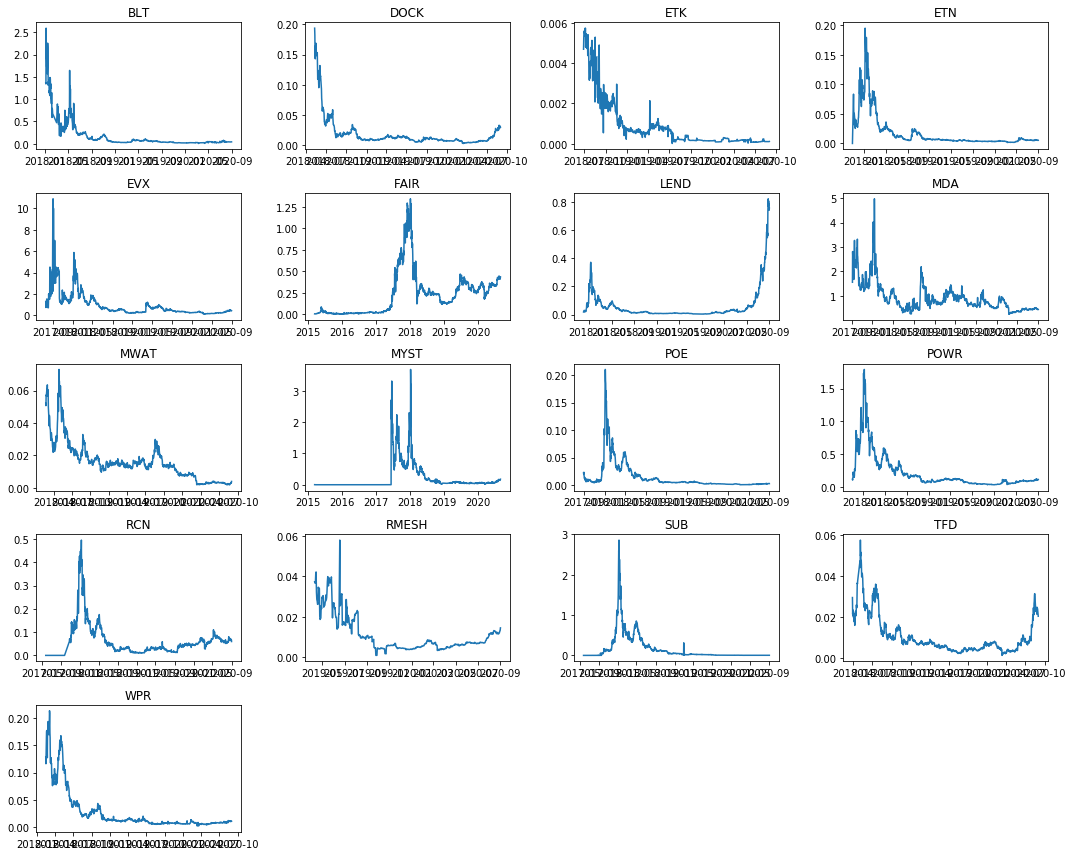

In [47]:
plt.figure(0,figsize=(15,12))
plots=[]
for i in range(5):
    for j in range(4): 
        if (i < 4) or ((i==4)&(j<1)):
            ax=plt.subplot2grid((5,4),(i,j))
            df=part_token_price[part_token_price['Token']==tokens[i*4+j]][['Time','Price']]
            ax.plot(df['Time'],df['Price'])
            ax.set_title(tokens[i*4+j])
plt.tight_layout()
plt.show()      

In [52]:
# use n_clt=3 for all clustering algorithms
from tslearn.utils import to_time_series
n_clt=3
new_df=pd.DataFrame()
for i in range(len(tokens)):
    df=to_time_series(part_token_price[part_token_price['Token']==tokens[i]][['Price']])
    model=TimeSeriesKMeans(n_clusters=3,metric='dtw',max_iter=10)
    model.fit(df)
    pred=model.fit_predict(df)
    temp_df=part_token_price[part_token_price['Token']==tokens[i]]
    temp_df=temp_df.copy()
    temp_df['label']=pred
    new_df=new_df.copy()
    new_df=pd.concat([new_df,temp_df],ignore_index=True)
new_df

,Token,Time,Price,label
0,BLT,2018-01-03,1.36600,1
1,BLT,2018-01-04,1.34200,1
2,BLT,2018-01-05,2.59200,1
3,BLT,2018-01-06,1.91200,1
4,BLT,2018-01-07,1.95600,1
...,...,...,...,...
18542,WPR,2020-08-28,0.01073,2
18543,WPR,2020-08-29,0.01068,2
18544,WPR,2020-08-30,0.01052,2
18545,WPR,2020-08-31,0.01154,2


In [58]:
# observe the labels of leaders
time_label=pd.merge(token_leaders,new_df,left_on=['Token','entry_time','Price'],right_on=['Token','Time','Price'])
time_label

,Token,Wallet_id,entry_time,Time_y,Price,Time,label
0,BLT,0x40eb2c0bd87b953273af6ec99ac204902a65b92e,2018-01-03,2018-01-03,1.3660,2018-01-03,1
1,BLT,0xe40a031442ae509f465ef3d5a5f01bc0e507a926,2018-01-03,2018-01-03,1.3660,2018-01-03,1
2,BLT,0xb528d2cafd2cc99fde613088fc7a7bde1cf3cb45,2018-01-03,2018-01-03,1.3660,2018-01-03,1
3,BLT,0x368eeff37b63f98bca2b03fe1ccaa082b01cd105,2018-01-03,2018-01-03,1.3660,2018-01-03,1
4,BLT,0x40ca70ef48e2a8c1d0f3e87596aefcac99c69ece,2018-01-03,2018-01-03,1.3660,2018-01-03,1
...,...,...,...,...,...,...,...
677384,WPR,0xd5fcab66d4ff6f8e73542c27d29b6bd0d35abd06,2018-03-29,2018-03-29,0.0959,2018-03-29,0
677385,WPR,0xbb6f69b20e9b8313ccf4c1e9f19779dc3e146364,2018-03-29,2018-03-29,0.0959,2018-03-29,0
677386,WPR,0xb28870588b427a0ff5e727c807cc85c4007bdb73,2018-03-29,2018-03-29,0.0959,2018-03-29,0
677387,WPR,0xc8c371af15303f077862ccc8141f1bc705dea5b0,2018-03-29,2018-03-29,0.0959,2018-03-29,0


In [89]:
ndays=max(new_df['Time'])-min(new_df['Time'])
ndays/=8
labels=[min(new_df['Time'])+i*ndays for i in range(9)]
labels

[datetime.date(2015, 3, 12),
 datetime.date(2015, 11, 17),
 datetime.date(2016, 7, 24),
 datetime.date(2017, 3, 31),
 datetime.date(2017, 12, 6),
 datetime.date(2018, 8, 13),
 datetime.date(2019, 4, 20),
 datetime.date(2019, 12, 26),
 datetime.date(2020, 9, 1)]

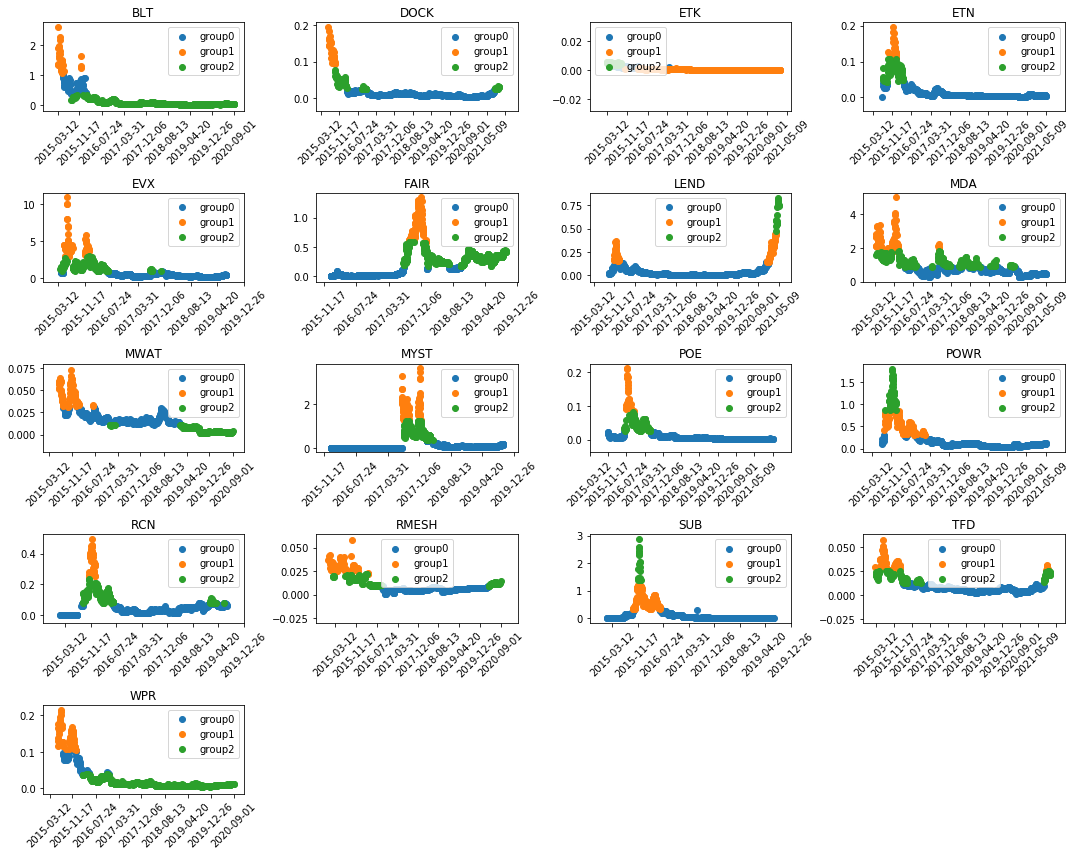

In [91]:
plt.figure(0,figsize=(15,12))
plots=[]
ndays=max(new_df['Time'])-min(new_df['Time'])
ndays/=8
labels=[min(new_df['Time'])+i*ndays for i in range(10)]
for i in range(5):
    for j in range(4): 
        if (i < 4) or ((i==4)&(j<1)):
            ax=plt.subplot2grid((5,4),(i,j))
            df=new_df[(new_df['Token']==tokens[i*4+j])&(new_df['label']==0)][['Time','Price']]
            ax.scatter(df['Time'],df['Price'],label='group0')
            df=new_df[(new_df['Token']==tokens[i*4+j])&(new_df['label']==1)][['Time','Price']]
            ax.scatter(df['Time'],df['Price'],label='group1')
            df=new_df[(new_df['Token']==tokens[i*4+j])&(new_df['label']==2)][['Time','Price']]
            ax.scatter(df['Time'],df['Price'],label='group2')
            ax.set_title(tokens[i*4+j])
            x_labels=[min(df)]
            ax.set_xticklabels(labels,rotation=45)
            ax.legend()
plt.tight_layout()
plt.show()      

In [63]:
time_label[['Token','label','Time']].groupby(by=['Token','label']).count()

Time
Token label        
BLT   0        4549
      1         618
      2         533
DOCK  0        1462
      1        5848
      2        3682
ETK   0         265
      1        9104
      2         158
ETN   0         395
      1         373
      2         101
EVX   0         364
      1       21308
      2       10192
FAIR  1       15518
      2       87048
LEND  0        6254
      1      245664
MDA   1        9340
      2        1717
MWAT  0        6123
      1        2826
MYST  1        6410
      2        3882
POE   0        2784
      1       23311
      2         658
POWR  0       21423
      1       18341
      2       19273
RCN   0        4167
      2       14261
RMESH 0          15
      1          93
      2          89
SUB   0        2896
      1        8270
      2       30397
TFD   1        1946
      2        3620
WPR   0       59691
      1       22420